In [3]:
# this notebook is to import and analyse the count of parameters in diff versions of GPT2


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from torchinfo import summary

import matplotlib_inline.backend_inline

In [2]:
#libraries for GPT models and theri tokenizer
from transformers import AutoModelForCausalLM, GPT2Tokenizer
tokenizer  = GPT2Tokenizer.from_pretrained('gpt2')

/Users/raeez/.pyenv/versions/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# dict of modelname: identifier

model_ids = {
    'small': 'gpt2', # 124M
    'medium': 'gpt2-medium', #355M
    'large': 'gpt2-large'#, #774M
    # 'xl':  'gpt2-xl'  # 1.6B (including this will really slow down the notebook
}

models = {} # this is the dict of models, key is name of model and value is the actual model
for name, id in model_ids.items():
    models[name] = AutoModelForCausalLM.from_pretrained(id)

In [4]:
models.keys()

dict_keys(['small', 'medium', 'large'])

In [5]:
for name, model in models.items():
    print(f'{sum(p.numel() for p in model.parameters()):13} parameters in gpt2-{name}')

    124439808 parameters in gpt2-small
    354823168 parameters in gpt2-medium
    774030080 parameters in gpt2-large


Compare GPT2-small with out "model5"

In [6]:
# you need to run some data through for summary() to work
ids = tokenizer.encode("This is a test. One that we have done countless times before.")
x = torch.tensor(ids, dtype=torch.long).unsqueeze(0) 
# model5 had 124439808 parameters

In [7]:
x

tensor([[ 1212,   318,   257,  1332,    13,  1881,   326,   356,   423,  1760,
         12925,  1661,   878,    13]])

In [8]:
sumry = summary(models['small'], input_data=x, col_names =['input_size','output_size','num_params'])
print(sumry)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
GPT2LMHeadModel                                    [1, 14]                   --                        --
├─GPT2Model: 1-1                                   [1, 14]                   --                        --
│    └─Embedding: 2-1                              [1, 14]                   [1, 14, 768]              38,597,376
│    └─Embedding: 2-2                              [1, 14]                   [1, 14, 768]              786,432
│    └─Dropout: 2-3                                [1, 14, 768]              [1, 14, 768]              --
│    └─ModuleList: 2-4                             --                        --                        --
│    │    └─GPT2Block: 3-1                         [1, 14, 768]              [1, 14, 768]              7,087,872
│    │    └─GPT2Block: 3-2                         [1, 14, 768]              [1, 14, 768]              7,087,872
│    │    └─GP

In [9]:
finalHeadCount = torch.numel(models['small'].lm_head.weight) #numel is no of elemnts in that tensor
print(f'Total trainable params: {sumry.total_params - finalHeadCount}')

Total trainable params: 124439808


In [10]:
models['small'].lm_head.weight.shape

torch.Size([50257, 768])

In [11]:
torch.numel(x)

14

In [12]:
models['small']#.transformer

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

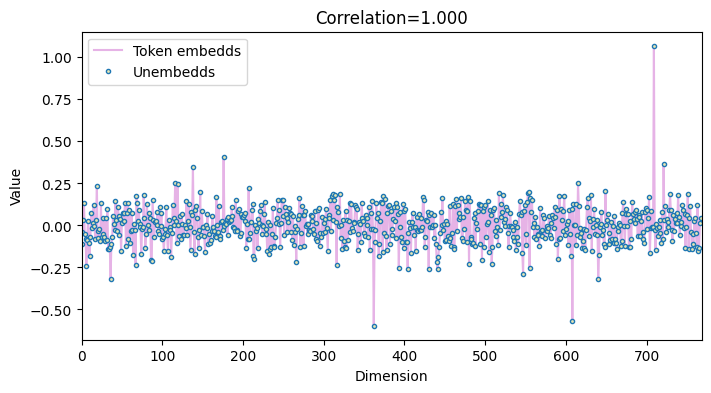

In [13]:
# show that token embedding and final output layer are same
plt.figure(figsize=(8,4))

tokW = models['small'].transformer.wte.weight[0].detach() #this is the emebedd of first token
head = models['small'].lm_head.weight[0].detach()

plt.plot(tokW, color=[.9,.7,.9],label='Token embedds')
plt.plot(head, 'o',markerfacecolor=[.9,.9,.7], markersize=3, label='Unembedds')

plt.legend()
plt.gca().set(xlabel='Dimension', ylabel='Value',xlim=[0,len(tokW)],
              title=f'Correlation={np.corrcoef(tokW,head)[0,1]:.3f}')
plt.show()

In [23]:
tokW = models['small'].transformer.wte.weight[0].detach()

In [24]:
tokW

tensor([-1.1010e-01, -3.9267e-02,  3.3108e-02,  1.3383e-01, -4.8476e-02,
        -7.8918e-02, -2.3977e-01, -8.9474e-02,  2.5255e-02, -1.0740e-01,
        -1.8115e-01, -6.7154e-02,  7.3914e-02, -1.6131e-02,  1.1662e-02,
         1.2450e-01, -1.9630e-03, -8.1503e-02,  3.3778e-02,  2.3648e-01,
        -7.7094e-02, -3.4552e-02, -2.3407e-02, -9.2770e-02,  1.3363e-01,
        -6.6103e-02, -5.0176e-02,  4.6405e-02, -7.0965e-02, -9.0733e-02,
         4.2812e-02, -8.8276e-02,  9.7773e-02, -1.3814e-01, -1.4034e-01,
        -1.2564e-01, -3.1738e-01, -1.0916e-01, -7.0847e-02,  5.8407e-02,
         7.8983e-03, -2.9746e-02,  1.4301e-01,  3.1137e-02, -3.1280e-02,
         1.1017e-01,  5.4944e-02, -5.8925e-02,  3.5598e-02, -1.5325e-01,
         1.5507e-02,  7.2158e-02,  2.7719e-02,  7.4660e-02,  1.3444e-01,
        -1.2046e-01,  7.3460e-02,  1.3207e-01, -8.1152e-02,  9.0484e-02,
        -1.0156e-01, -3.1801e-02,  7.5770e-02, -2.6173e-02, -1.7774e-01,
         5.6041e-03, -2.7483e-02, -2.3783e-01,  1.7

In [25]:
tokW.shape

torch.Size([768])

In [26]:
head

tensor([-1.1010e-01, -3.9267e-02,  3.3108e-02,  1.3383e-01, -4.8476e-02,
        -7.8918e-02, -2.3977e-01, -8.9474e-02,  2.5255e-02, -1.0740e-01,
        -1.8115e-01, -6.7154e-02,  7.3914e-02, -1.6131e-02,  1.1662e-02,
         1.2450e-01, -1.9630e-03, -8.1503e-02,  3.3778e-02,  2.3648e-01,
        -7.7094e-02, -3.4552e-02, -2.3407e-02, -9.2770e-02,  1.3363e-01,
        -6.6103e-02, -5.0176e-02,  4.6405e-02, -7.0965e-02, -9.0733e-02,
         4.2812e-02, -8.8276e-02,  9.7773e-02, -1.3814e-01, -1.4034e-01,
        -1.2564e-01, -3.1738e-01, -1.0916e-01, -7.0847e-02,  5.8407e-02,
         7.8983e-03, -2.9746e-02,  1.4301e-01,  3.1137e-02, -3.1280e-02,
         1.1017e-01,  5.4944e-02, -5.8925e-02,  3.5598e-02, -1.5325e-01,
         1.5507e-02,  7.2158e-02,  2.7719e-02,  7.4660e-02,  1.3444e-01,
        -1.2046e-01,  7.3460e-02,  1.3207e-01, -8.1152e-02,  9.0484e-02,
        -1.0156e-01, -3.1801e-02,  7.5770e-02, -2.6173e-02, -1.7774e-01,
         5.6041e-03, -2.7483e-02, -2.3783e-01,  1.7

In [27]:
head.shape

torch.Size([768])

In [32]:
models['small'].lm_head.weight.shape

torch.Size([50257, 768])

In [33]:
models['small'].transformer.wte.weight.shape

torch.Size([50257, 768])

weights and bias params, as %of total params


In [35]:
for name, mat in models['small'].named_parameters():
    print(name)

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [50]:
# init
param_counts = np.zeros((len(models.keys()),3),dtype=int)

for idx, (modelname,model) in enumerate(models.items()):
    # get the summary for all params
    sumry = summary(model, input_data=x, col_names =['input_size','output_size','num_params'])
    finalHeadCount = torch.numel(model.lm_head.weight)
    param_counts[idx,2] = sumry.total_params-finalHeadCount

    #llop through all params and increment param count
    for layername, mat in model.named_parameters():
        if 'weight' in layername:
            param_counts[idx,0] += torch.numel(mat)
        elif 'bias' in layername:
            param_counts[idx,1] += torch.numel(mat)

    print(f'\n****Model "{modelname}":')
    print(f'Total weights: {param_counts[idx,0]:13,d} ({100* param_counts[idx,0]/param_counts[idx,2]:6.3f}% of all params)')
    print(f'Total biases: {param_counts[idx,1]:13,d} ({100* param_counts[idx,1]/param_counts[idx,2]:6.3f}% of all params)')


****Model "small":
Total weights:   124,337,664 (99.918% of all params)
Total biases:       102,144 ( 0.082% of all params)

****Model "medium":
Total weights:   354,551,808 (99.924% of all params)
Total biases:       271,360 ( 0.076% of all params)

****Model "large":
Total weights:   773,521,920 (99.934% of all params)
Total biases:       508,160 ( 0.066% of all params)


In [51]:
# IMP: 99% of params in the model are weights and <1% are biases

In [53]:
# 124439808
124337664 + 102144

124439808

parameters in attention vs MLP blocks

In [52]:
# init
param_counts = np.zeros((len(models.keys()),3),dtype=int)

for idx, (modelname,model) in enumerate(models.items()):
    # get the summary for all params
    sumry = summary(model, input_data=x, col_names =['input_size','output_size','num_params'])
    finalHeadCount = torch.numel(model.lm_head.weight)
    param_counts[idx,2] = sumry.total_params-finalHeadCount

    #llop through all params and increment param count
    for layername, mat in model.named_parameters():
        if ('attn' in layername) and ('weight' in layername):
            param_counts[idx,0] += torch.numel(mat)
        elif 'mlp' in layername and ('weight' in layername):
            param_counts[idx,1] += torch.numel(mat)

    print(f'\n****Model "{modelname}":')
    print(f'Attn weights: {param_counts[idx,0]:13,d} ({100* param_counts[idx,0]/param_counts[idx,2]:6.3f}% of all params)')
    print(f'MLP weights: {param_counts[idx,1]:13,d} ({100* param_counts[idx,1]/param_counts[idx,2]:6.3f}% of all params)')


****Model "small":
Attn weights:    28,311,552 (22.751% of all params)
MLP weights:    56,623,104 (45.502% of all params)

****Model "medium":
Attn weights:   100,663,296 (28.370% of all params)
MLP weights:   201,326,592 (56.740% of all params)

****Model "large":
Attn weights:   235,929,600 (30.481% of all params)
MLP weights:   471,859,200 (60.961% of all params)


In [54]:
# MLP weights are twice the size compared to attn weights

How many layernorm params

In [55]:
# init
param_counts = np.zeros((len(models.keys()),3),dtype=int)

for idx, (modelname,model) in enumerate(models.items()):
    # get the summary for all params
    sumry = summary(model, input_data=x, col_names =['input_size','output_size','num_params'])
    finalHeadCount = torch.numel(model.lm_head.weight)
    param_counts[idx,2] = sumry.total_params-finalHeadCount

    #llop through all params and increment param count
    for layername, mat in model.named_parameters():
        if ('ln_' in layername) and ('weight' in layername):
            param_counts[idx,0] += torch.numel(mat)
        elif 'ln_' in layername and ('bias' in layername):
            param_counts[idx,1] += torch.numel(mat)

    print(f'\n****Model "{modelname}":')
    print(f'LayerNorm weights: {param_counts[idx,0]:13,d} ({100* param_counts[idx,0]/param_counts[idx,2]:6.3f}% of all params)')
    print(f'LayerNorm biases: {param_counts[idx,1]:13,d} ({100* param_counts[idx,1]/param_counts[idx,2]:6.3f}% of all params)')


****Model "small":
LayerNorm weights:        19,200 ( 0.015% of all params)
LayerNorm biases:        19,200 ( 0.015% of all params)

****Model "medium":
LayerNorm weights:        50,176 ( 0.014% of all params)
LayerNorm biases:        50,176 ( 0.014% of all params)

****Model "large":
LayerNorm weights:        93,440 ( 0.012% of all params)
LayerNorm biases:        93,440 ( 0.012% of all params)
